In [281]:
from functools import partial

import arviz as az
import jax
import jax.numpy as jnp
import jax.random as random
import jax.scipy.special as special
import jax.scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from jax import lax
from pears import kde2d, pears

In [245]:
@partial(jax.jit, static_argnums=(0,))
def rwmh(target, x, temps, stepsize, key, *args):
    n_temps, n_dims = x.shape
    keys = random.split(key, 2)

    # normal update, with temperatures
    x_new = random.normal(keys[0], shape=x.shape) * stepsize + x
    log_accept = target(x_new, *args) - target(x, *args)
    log_accept_with_temp = log_accept / temps
    u = jnp.log(random.uniform(keys[1], shape=log_accept_with_temp.shape))
    new = jnp.where((u < log_accept_with_temp)[..., None], x_new, x)
    # print(new)
    return new


# with coupling/swap update
@partial(jax.jit, static_argnums=(0, 1))
def partemp(kern, target, x, temps, stepsize, key, *args):
    n_temps, n_dims = x.shape
    keys = random.split(key, 2)

    new = kern(target, x, temps, stepsize, key, *args)
    zero_one = random.randint(keys[0], shape=(), minval=0, maxval=2)  # 0 or 1
    ix_i = jnp.array([zero_one + 2 * i for i in range(n_temps // 2)])
    ix_j = ix_i + 1
    swap_ix = jnp.arange(n_temps)
    swap_ix = swap_ix.at[ix_i].set(ix_j)
    swap_ix = swap_ix.at[ix_j].set(ix_i)
    swapped = new[swap_ix]
    temps_swapped = temps[swap_ix]

    swap11 = target(new, *args) / temps
    swap22 = target(swapped, *args) / temps_swapped
    swap21 = target(swapped, *args) / temps
    swap12 = target(new, *args) / temps_swapped

    proposal = swap12 + swap21
    current = swap11 + swap22

    # energy = -log_prob
    energy_diff = target(swapped, *args) - target(new, *args)
    inv_temp_diff = 1.0 / temps - 1.0 / temps_swapped

    log_accept_with_swap = energy_diff * inv_temp_diff  # equal for items being swapped

    # print("swap prob", jnp.exp(log_accept_with_swap))

    u = jnp.log(random.uniform(keys[1], shape=log_accept_with_swap.shape))
    u = u.at[ix_j].set(u[ix_i])  # u for items to be swapped should be equal
    new_swapped = jnp.where((u < log_accept_with_swap)[..., None], swapped, new)
    return new_swapped

In [339]:
@jax.jit
def mix1d(x):
    return special.logsumexp(
        jnp.array(
            [
                stats.norm.logpdf(x, -3.0, 0.25),
                stats.norm.logpdf(x, 0.0, 0.4),
                stats.norm.logpdf(x, 2.0, 0.1),
            ]
        ),
        axis=0,
    ).sum(axis=-1)

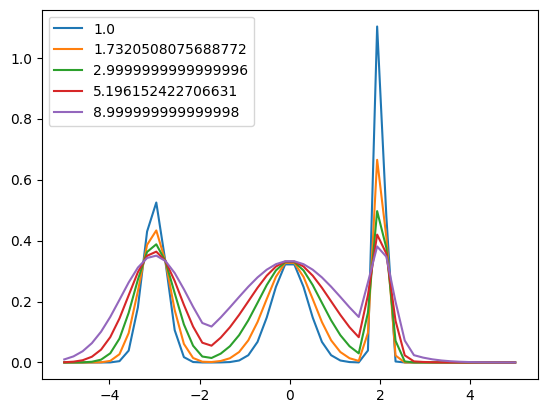

In [340]:
xs = np.linspace(-5, 5).reshape(-1, 1)
ys = mix1d(xs)
for t in [np.sqrt(3) ** i for i in range(5)]:
    plt.plot(xs, jnp.exp(ys / t) / 3, label=t)
plt.legend()

In [341]:
partemp(rwmh, mix1d, init[0], temps, 0.1, random.PRNGKey(2))

DeviceArray([[1.0673317],
             [1.0049506],
             [1.1402055],
             [1.1534237],
             [1.032415 ],
             [1.0057143],
             [1.       ]], dtype=float32)

In [342]:
jax.vmap(rwmh, in_axes=(None, 0, None, None, 0))(
    mix1d, init, temps[::-1], 0.1, random.split(key, 4)
).shape

(4, 7, 1)

In [1248]:
x = random.normal(key, shape=(9,))
x

DeviceArray([-0.3721109 ,  0.26423115, -0.18252768, -0.7368197 ,
              0.44973662, -0.1521442 , -0.67135346, -0.5908641 ,
              0.73168886], dtype=float32)

In [320]:
@partial(jax.jit, static_argnums=(0, 1, 5))
def sample(target, kern, x, stepsize, temps, steps, seed=0, *args):
    # tempered_target = make_tempered_fn(target)
    # assert temps.size % 2 == 1  # odd # of temps
    # assert jnp.all(jnp.diff(temps) < 0)  # temps are decreasing
    # assert temps[-1] == 1.0  # last temp is 1

    @jax.jit
    def inner_fn(carry, i):
        key, x = carry
        key, subkey = random.split(key)
        y = kern(target, x, temps, stepsize, subkey, *args)
        return (key, y), y

    key = random.PRNGKey(seed)
    _, stacked = lax.scan(inner_fn, (key, x), None, length=steps)

    return stacked

In [383]:
dim = 1
chains = 5
niter = 20000
nwarmup = 5000
nthin = 10
temps = jnp.array([2**i for i in range(7)])[::-1]
key = random.PRNGKey(0)
# init = random.normal(key, shape=(chains, temps.size, dim))
init = jnp.ones((chains, temps.size, dim))

In [384]:
sample(mix1d, rwmh, init[0], 0.1, temps, niter, 0).shape

(20000, 7, 1)

In [385]:
chain = jax.vmap(sample, in_axes=(None, None, 0, None, None, None, 0))(
    mix1d, partial(partemp, rwmh), init, 0.1, temps, niter, jnp.arange(chains)
)[:, nwarmup:, ...][:, ::nthin, ...]
azchain = dict(x=chain[:, :, -1, :])

In [386]:
azchain["x"].shape

(5, 1500, 1)

In [387]:
az.summary(azchain)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x[0],-0.278,2.064,-3.28,2.175,0.119,0.085,410.0,2967.0,1.01


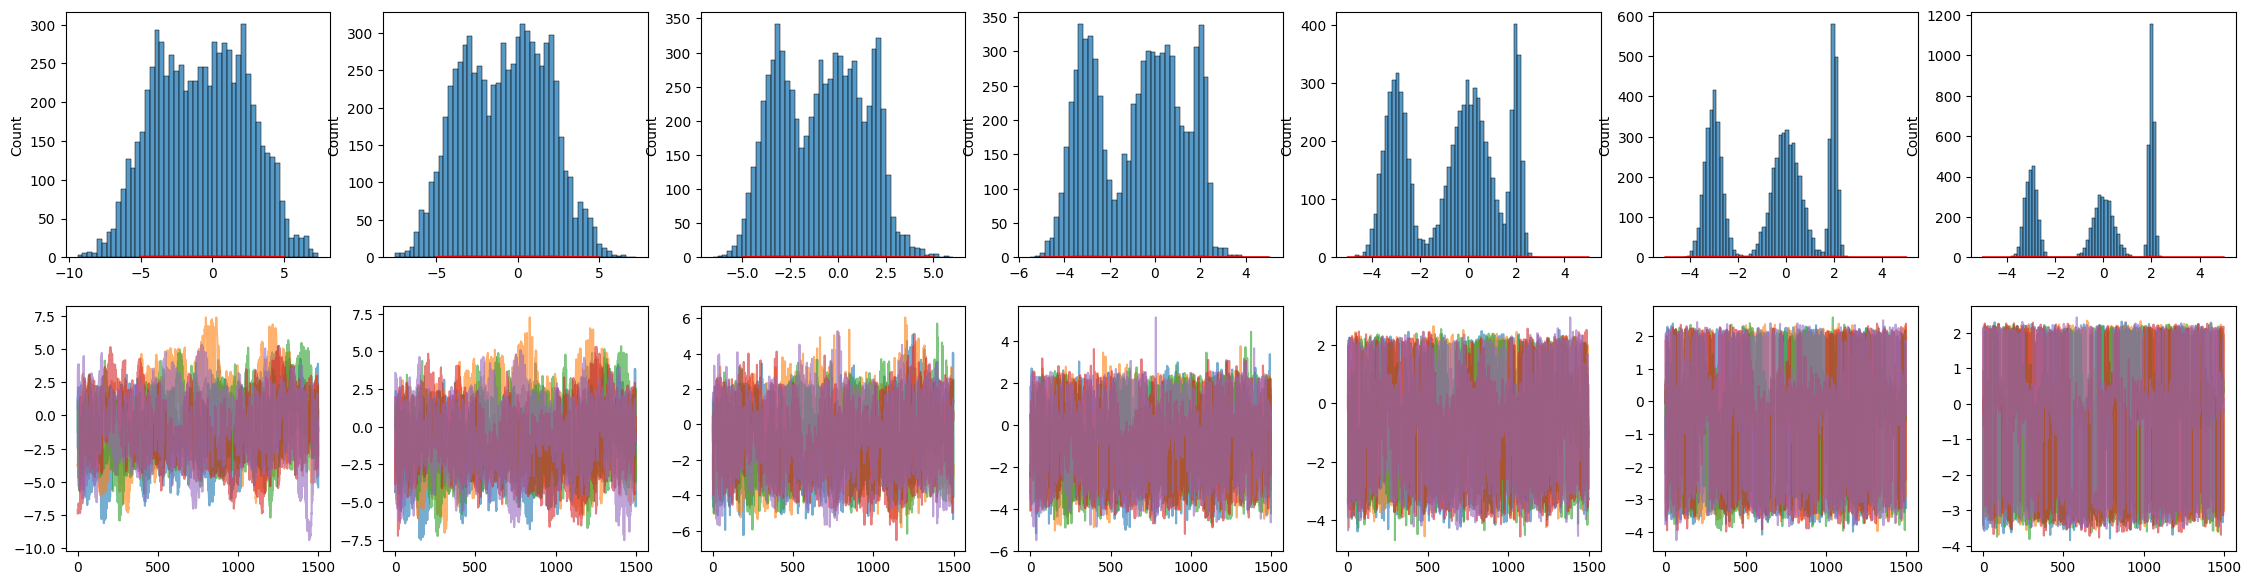

In [388]:
fig, ax = plt.subplots(2, temps.size, figsize=(temps.size * 4, 7))
for i in range(temps.size):
    sns.histplot(chain[:, :, i, 0].ravel(), bins=50, ax=ax[0, i])
    ax[0, i].plot(xs, np.exp(logpdf(xs) / temps[i]), c="r")
    for c in range(chains):
        ax[1, i].plot(chain[c, :, i, 0], alpha=0.6)

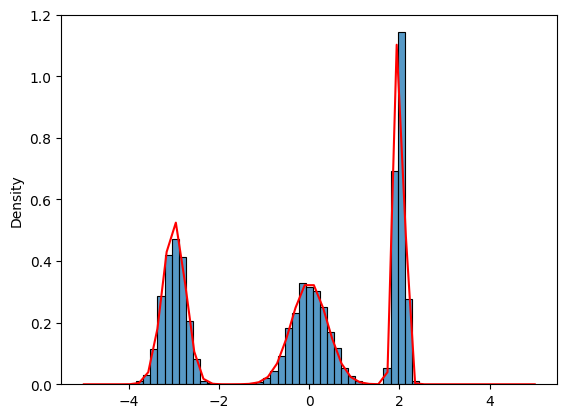

In [389]:
sns.histplot(chain[:, :, -1, :].ravel(), stat="density", bins=40)
plt.plot(xs, np.exp(ys) / 3, c="r")

In [348]:
@jax.jit
def mix2d(x):
    return special.logsumexp(
        jnp.array(
            [
                stats.multivariate_normal.logpdf(
                    x, jnp.array([1.5, 2.5]), jnp.array([[1.0, 0.9], [0.9, 1.0]])
                ),
                stats.multivariate_normal.logpdf(
                    x, jnp.array([-3.0, -1.0]), jnp.array([[0.3, -0.5], [-0.5, 2.0]])
                ),
            ]
        ).T,
        axis=1,
    )

In [349]:
xr = jnp.linspace(-5, 5)
yr = jnp.linspace(-5, 5)
xx, yy = jnp.meshgrid(xr, yr)
xxyy = jnp.stack((xx.ravel(), yy.ravel())).T
zz = mix2d(xxyy).reshape(xx.shape)

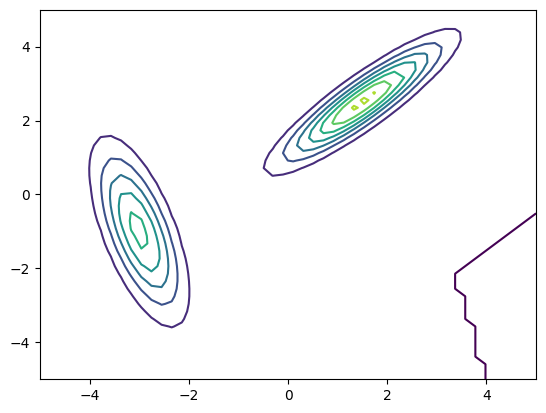

In [350]:
plt.contour(xx, yy, jnp.exp(zz))

In [390]:
dim = 2
chains = 4
niter = 25000
nwarmup = 5000
nthin = 10
temps = jnp.array([2**i for i in range(7)])[::-1]
key = random.PRNGKey(0)
# init = random.normal(key, shape=(chains, temps.size, dim))
init = jnp.zeros((chains, temps.size, dim))

In [391]:
chain = jax.vmap(sample, in_axes=(None, None, 0, None, None, None, 0))(
    mix2d, partial(partemp, rwmh), init, 0.2, temps, niter, jnp.arange(chains)
)[:, nwarmup:, ...][:, ::nthin, ...]
azchain = dict(x=chain[:, :, -1, 0], y=chain[:, :, -1, 1])

In [392]:
az.summary(azchain)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x,-0.674,2.356,-3.947,2.779,0.108,0.077,783.0,3023.0,1.01
y,0.814,2.079,-2.896,4.094,0.095,0.067,587.0,2944.0,1.00


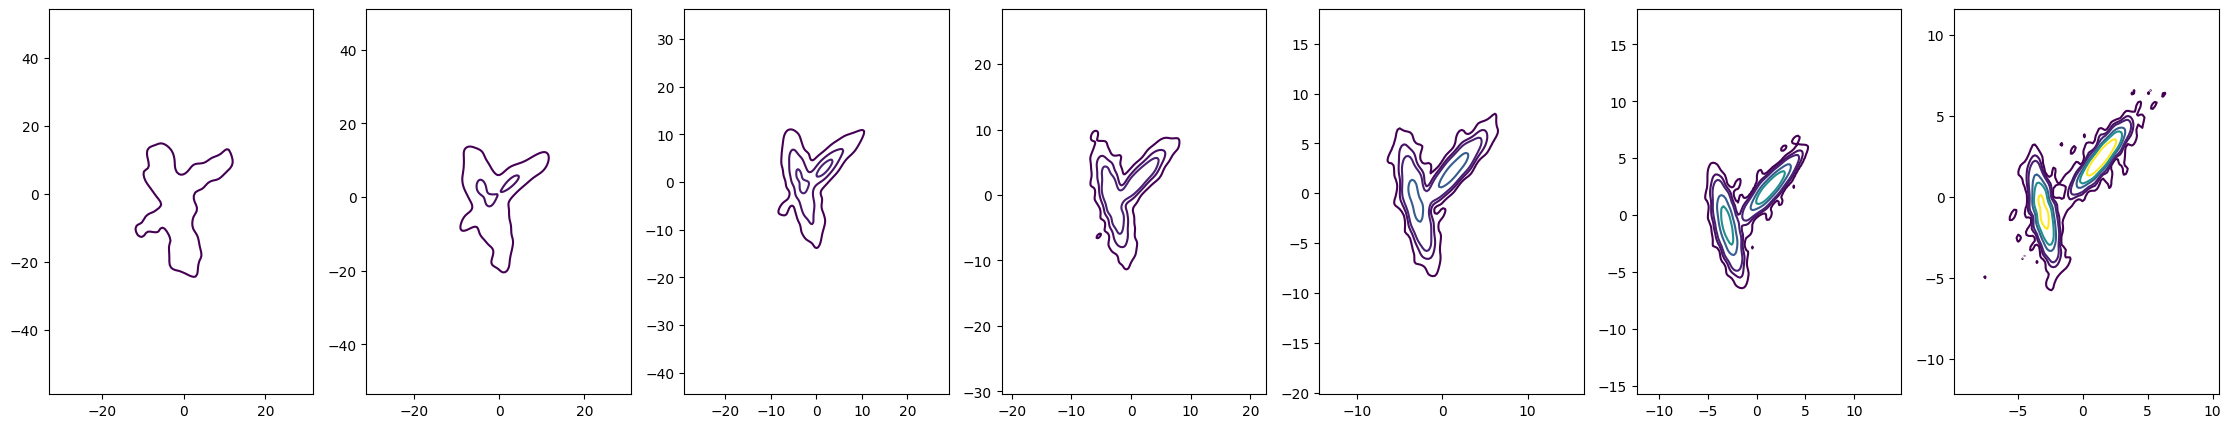

In [393]:
fig, ax = plt.subplots(1, temps.size, figsize=(temps.size * 4, 5))
for t in range(temps.size):
    c = chain[:, :, t, :].reshape(-1, 2)
    xy, z = kde2d(c[:, 0], c[:, 1])
    ax[t].contour(xy[0], xy[1], z, levels=[0.001, 0.005, 0.01, 0.03, 0.05, 0.1])

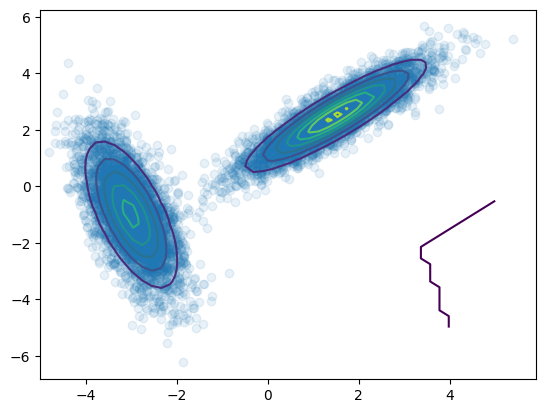

In [394]:
plt.contour(xx, yy, jnp.exp(zz))
plt.scatter(azchain["x"].ravel(), azchain["y"].ravel(), alpha=0.1)

In [413]:
@jax.jit
def funnel(x):
    ly = stats.norm.logpdf(x[:, 1], 0.0, 2.5)
    lx = stats.norm.logpdf(x[:, 0], 0.0, jnp.exp(x[:, 1] / 2))
    return ly + lx

In [414]:
xr = jnp.linspace(-2, 2)
yr = jnp.linspace(-8, 2)
xx, yy = jnp.meshgrid(xr, yr)
xxyy = jnp.stack((xx.ravel(), yy.ravel())).T
zz = logpdf(xxyy).reshape(xx.shape)

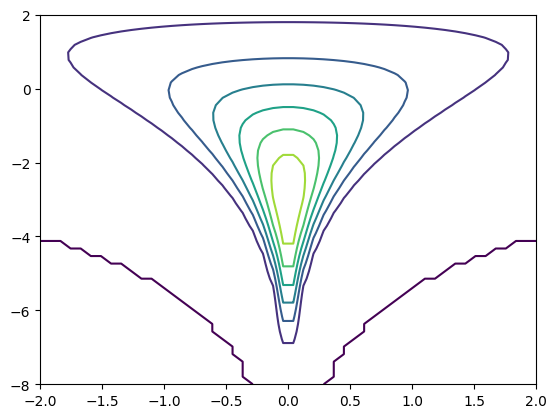

In [415]:
plt.contour(xx, yy, jnp.exp(funnel(xxyy).reshape(xx.shape)))

In [419]:
dim = 2
chains = 4
niter = 50000
nwarmup = 5000
nthin = 20
temps = jnp.array([3**i for i in range(9)])[::-1]
key = random.PRNGKey(0)
init = random.normal(key, shape=(chains, temps.size, dim))
chain = jax.vmap(sample, in_axes=(None, None, 0, None, None, None, 0))(
    funnel, partial(partemp, rwmh), init, 0.1, temps, niter, jnp.arange(chains)
)[:, nwarmup:, ...][:, ::nthin, ...]
azchain = dict(x=np.array(chain[:, :, -1, 0]), y=np.array(chain[:, :, -1, 1]))

In [420]:
az.summary(azchain)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x,-0.312,2.420,-5.587,2.751,0.103,0.073,413.0,400.0,1.02
y,-0.375,2.429,-4.711,4.337,0.231,0.164,110.0,323.0,1.03


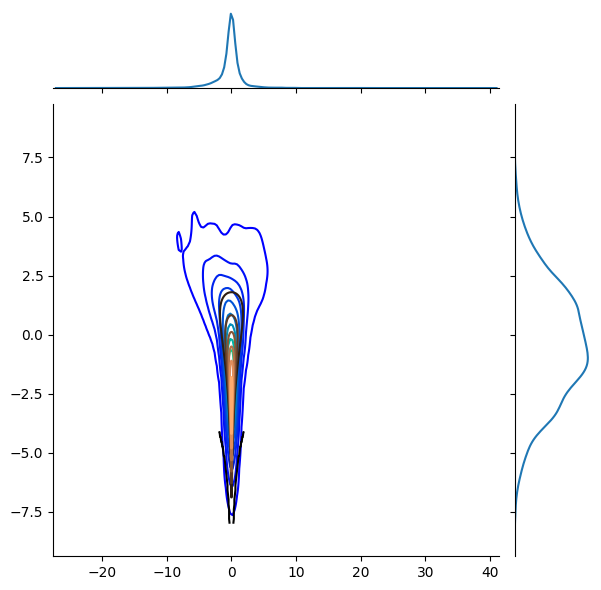

In [421]:
sns.jointplot(
    x=chain[:, :, -1, 0].ravel(),
    y=chain[:, :, -1, 1].ravel(),
    kind="kde",
    cmap="winter",
)
plt.contour(xx, yy, jnp.exp(funnel(xxyy).reshape(xx.shape)), cmap="copper")